<a href="https://colab.research.google.com/github/firarru/Text-Mining/blob/main/UTS_Text_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Crawling Twitter**

In [ ]:
# !sudo apt-get update
# !sudo apt-get install -y ca-certificates curl gnupg
# !sudo mkdir -p /etc/apt/keyrings
# !curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

# !NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

# !sudo apt-get update
# !sudo apt-get install nodejs -y

# !node -v

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [73.0 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,694 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRe

In [ ]:
# twt_auth_token = '6829383d17b8c8b4213cee7d62ed94761c481ac7'

In [ ]:
# filename = 'data_tweet.csv'

# search_keyword = 'konsumtif lang:id since:2020-01-01'
# limit = 900

# !npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twt_auth_token}

⠙⠹⠸⠼⠴Tweet Harvest [v2.6.1]

Research by Helmi Satria
Use it for Educational Purposes only!

This script uses Chromium Browser to crawl data from Twitter with your Twitter auth token.
Please enter your Twitter auth token when prompted.

Note: Keep your access token secret! Don't share it with anyone else.
Note: This script only runs on your local device.


Opening twitter search page...


-- Scrolling... (1) (2) (3)
Filling in keywords: konsumtif lang:id since:2020-01-01

 (4)

Your tweets saved to: /content/tweets-data/data_tweet.csv
Total tweets saved: 20


Your tweets saved to: /content/tweets-data/data_tweet.csv
Total tweets saved: 40

-- Scrolling... (1) (2) (3) (4) (5)

Your tweets saved to: /content/tweets-data/data_tweet.csv
Total tweets saved: 60

-- Scrolling... (1)

Your tweets saved to: /content/tweets-data/data_tweet.csv
Total tweets saved: 79

-- Scrolling... (1)

Your tweets saved to: /content/tweets-data/data_tweet.csv
Total tweets saved: 98

-- Scrolling... (1) (2) (3)

In [ ]:
# import pandas as pd

# file_path = f"tweets-data/{filename}"

# df = pd.read_csv(file_path, delimiter=",")

# df

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1912752541341024470,Thu Apr 17 06:18:37 +0000 2025,0,Wkwkwwk ....para pebisnis sejak dahulu kala pa...,1912752541341024470,NaN,NaN,in,Semarang middle Java Indonesia,0,0,0,https://x.com/soerjoadjigmail/status/191275254...,1745669821,soerjoadjigmail
1,1912724055062639095,Thu Apr 17 04:49:19 +0000 2025,0,@gausahsokep beli soalnya abi bilang gaboleh k...,1912730068415353137,NaN,gausahsokep,in,fa 40% rl 60%,0,0,0,https://x.com/d_udo9/status/1912730068415353137,1269483431416586241,d_udo9
2,1912711637817303452,Thu Apr 17 03:36:05 +0000 2025,0,https://t.co/FwycviLqYk di bodohin sama yg kat...,1912711637817303452,NaN,NaN,in,west,0,1,0,https://x.com/irzairham/status/191271163781730...,369305071,irzairham
3,1912696407003394437,Thu Apr 17 03:34:26 +0000 2025,0,@idosdr Konsumtif sesuai budget aja sih selama...,1912711221562028135,NaN,idosdr,in,NaN,0,0,0,https://x.com/sultanfrozen/status/191271122156...,536024858,sultanfrozen
4,1912693483623879144,Thu Apr 17 03:07:52 +0000 2025,0,@pendicornn bisa kak asal ga teralu konsumtif,1912704536290201796,NaN,pendicornn,in,NaN,0,1,0,https://x.com/lightyear_buzz_/status/191270453...,1376463122223964164,lightyear_buzz_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1903596333673427168,Sun Mar 23 03:05:38 +0000 2025,0,@koilokil @tanyakanrl Aku pake dan ga ngerasa ...,1903644279890993447,NaN,koilokil,in,NaN,0,1,0,https://x.com/boraphoriaa/status/1903644279890...,1458568506853629953,boraphoriaa
541,1903642872697499804,Sun Mar 23 03:00:03 +0000 2025,0,Ngaji Fiqih Filantropi NU Care-LAZISNU x NU On...,1903642872697499804,https://pbs.twimg.com/media/GmnJUwsbQAAH_Ib.jpg,NaN,in,"Jakarta Pusat, DKI Jakarta",0,0,0,https://x.com/nucare_lazisnu/status/1903642872...,463330666,nucare_lazisnu
542,1903596333673427168,Sun Mar 23 02:56:01 +0000 2025,0,@koilokil @tanyakanrl aku pake dan ga merasa k...,1903641855809692134,NaN,koilokil,in,she/her,0,0,0,https://x.com/pacarkunana/status/1903641855809...,1213467929909460992,pacarkunana
543,1903639139007791472,Sun Mar 23 02:49:14 +0000 2025,0,@tanyarlfes Overload kalau bulan ramadhan nder...,1903640149826900176,NaN,tanyarlfes,in,Indonesia,0,0,0,https://x.com/2304dotorii/status/1903640149826...,1064787512822947841,2304dotorii


In [ ]:
# df = df[['full_text', 'username']]
# df = df[df['username'] != 'grok']

In [ ]:
# df.shape

(542, 2)

In [ ]:
# df.to_excel('Data Tweet Konsumtif.xlsx')

In [ ]:
import pandas as pd
import re
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# from sklearn.ann import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [134]:
df = pd.read_excel('https://raw.githubusercontent.com/firarru/Text-Mining/main/Dataset/Data%20Tweet%20Konsumtif%20labeling.xlsx')
df

,full_text,username,label
0,@gausahsokep beli soalnya abi bilang gaboleh k...,d_udo9,0
1,@idosdr Konsumtif sesuai budget aja sih selama...,sultanfrozen,1
2,@pendicornn bisa kak asal ga teralu konsumtif,lightyear_buzz_,0
3,@sultanfrozen Modar gak ada yg tau nanti malah...,idosdr,1
4,@inimenik jangan konsumtif ya ka,artefactsofyou,0
...,...,...,...
441,"Bayar kelas online, beli e-book, ikut webinar—...",hopeitsfine,1
442,Jajanin kucing sampe punya lebih banyak snack ...,hw4n9dory,1
443,"Jajan membuatku konsumtif, harus dikurangin ni...",clearytianoviko,0
444,"Gue gak boros, gue cuma terlalu konsumtif buat...",k3cipir,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  446 non-null    object
 1   username   446 non-null    object
 2   label      446 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.6+ KB


In [135]:
df = df[['full_text', 'label']]

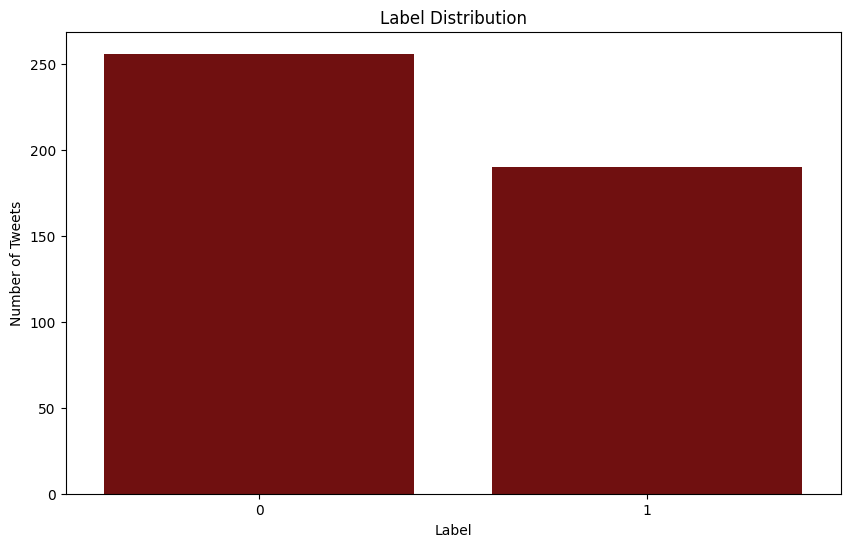

In [136]:
label_count = df['label'].value_counts()
label_count
plt.figure(figsize=(10, 6))
sns.barplot(x=label_count.index, y=label_count.values, color='maroon')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.show()

# **PREPROCESSING**

## A. CASE FOLDING

In [137]:
# def convert_text(text):
#     try:
#         teks = ast.literal_eval(text)
#         return " ".join([word.lower() for word in teks])
#     except (ValueError, SyntaxError):
#         if isinstance(text, str):
#           return " ".join([word.lower() for word in text.split()])
#         return text

df['full_text'] = df['full_text'].str.lower()

<ipython-input-137-28fce46c9ef4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].str.lower()


## B. CLEANING

In [138]:
def cleaning_text(text) :
    text = re.sub(r'#\w+', '', text) #remove hashtag
    text = re.sub(r'\b\w*\d\w*\b', '', text) #remove words with numbers in the middle
    text = re.sub(r'@\S+', '', text) #remove mentions (@username)
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) #remove special characters
    return text

In [139]:
df['cleaning'] = df['full_text'].apply(cleaning_text)

## C. TOKENIZING

In [140]:
nltk.download('punkt_tab')
df['tokenize'] = df['cleaning'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [141]:
df.tail(5)

,full_text,label,cleaning,tokenize
441,"bayar kelas online, beli e-book, ikut webinar—...",1,bayar kelas online beli ebook ikut webinarkons...,"[bayar, kelas, online, beli, ebook, ikut, webi..."
442,jajanin kucing sampe punya lebih banyak snack ...,1,jajanin kucing sampe punya lebih banyak snack ...,"[jajanin, kucing, sampe, punya, lebih, banyak,..."
443,"jajan membuatku konsumtif, harus dikurangin ni...",0,jajan membuatku konsumtif harus dikurangin nih...,"[jajan, membuatku, konsumtif, harus, dikurangi..."
444,"gue gak boros, gue cuma terlalu konsumtif buat...",1,gue gak boros gue cuma terlalu konsumtif buat ...,"[gue, gak, boros, gue, cuma, terlalu, konsumti..."
445,@tempodotco gue sih berharap masyarakat indone...,0,gue sih berharap masyarakat indonesia berhent...,"[gue, sih, berharap, masyarakat, indonesia, be..."


## D. STOPWORD

In [142]:
df_slang = pd.read_csv('https://raw.githubusercontent.com/firarru/Text-Mining/main/Dataset/slang.csv', sep=';')
df['filtering'] = df['tokenize'].apply(lambda x: [df_slang[df_slang['slang'] == word]['formal'].values[0] if df_slang[df_slang['slang'] == word]['formal'].values.size > 0 else word for word in x])

In [143]:
nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))
df['filtering'] = df['filtering'].apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [144]:
custom_stopwords = set([
    'woy', 'wow', 'haha', 'huhu', 'wkwk', 'hehe', 'yah', 'loh', 'uh', 'deh',
    'anjay', 'asw', 'cie', 'ckck', 'hadeh', 'anjir', 'lah', 'sih', 'dong',
    'nih', 'deh', 'ya', 'kan', 'dong', 'mah', 'ga', 'nggak', 'gak', 'sih', 'noh'
])

df['filtering'] = df['filtering'].apply(lambda x: [word for word in x if word not in custom_stopwords])

## E. STEMMING

In [95]:
pip install sastrawi

In [146]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

df['stemming'] = df['filtering'].apply(lambda x: [stemmer.stem(word) for word in x])

In [147]:
print(df['stemming'])

0            [beli, abi, bilang, tidak boleh, konsumtif]
1      [konsumtif, sesuai, biaya, ngelebihin, batas, ...
2                                [kakak, alu, konsumtif]
3          [modar, nikmat, duit, ayo, konsumtif, gaesss]
4                                     [konsumtif, kakak]
                             ...                        
441    [bayar, kelas, daring, beli, ebook, webinarkon...
442                  [jajanin, kucing, snack, konsumtif]
443                     [jajan, buat, konsumtif, rangin]
444                           [boros, konsumtif, senang]
445    [harap, masyarakat, indonesia, henti, konsumti...
Name: stemming, Length: 446, dtype: object


## F. TF-IDF

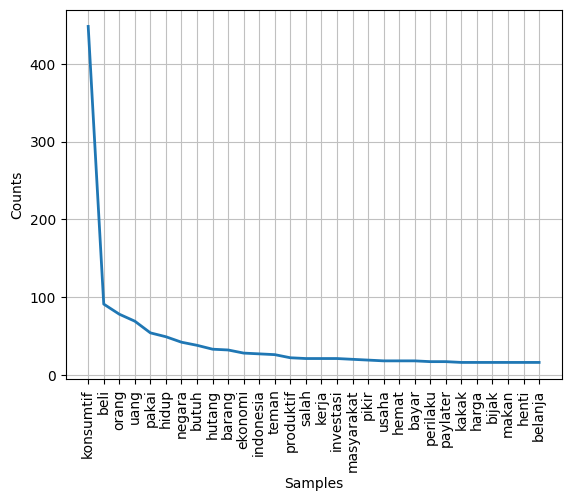

In [148]:
all_words = []
for text in df['stemming']:
    all_words.extend(text)

fdist = FreqDist(all_words)
# print(fdist.most_common(20))

fdist.plot(30,cumulative=False)
plt.show()

In [206]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [207]:
df['stemming'] = df['stemming'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['stemming'])
# join = " ".join(df['stemming'])
# tfidf = vectorizer.fit_transform([tfidf_matrix])
tfidf_scaled = scaler.fit_transform(tfidf.toarray())

In [210]:
tfidf_array = tfidf.toarray()
feature_names = vectorizer.get_feature_names_out()

avg_tfidf = np.mean(tfidf_array, axis=0)
df_tfidf = pd.DataFrame({
    'Kata': feature_names,
    'Rata_rata_TFIDF': avg_tfidf
})
df_tfidf.sort_values(by='Rata_rata_TFIDF', ascending=False)

,Kata,Rata_rata_TFIDF
861,konsumtif,0.083383
183,beli,0.029919
1283,orang,0.026824
1301,pakai,0.023730
1823,uang,0.022626
...,...,...
1386,podcast,0.000350
1765,tetap,0.000350
156,barista,0.000350
424,dominan,0.000350


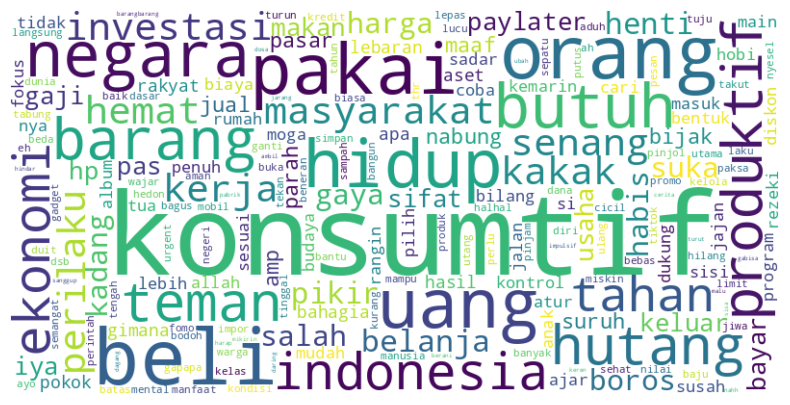

In [215]:
from wordcloud import WordCloud

wordcloud_dict = dict(zip(df_tfidf['Kata'], df_tfidf['Rata_rata_TFIDF']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Split Data**

In [217]:
X = tfidf_scaled
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [218]:
print("Training data :", X_train.shape)
print("Testing data :", X_test.shape)

Training data : (356, 1905)
Testing data : (90, 1905)


# **SVM**

In [220]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train_vec, y_train)

svm_pred = svm_rbf.predict(X_test_vec)

In [221]:
df_svm = pd.DataFrame({'Actual': y_test, 'Predicted': svm_pred})
df_svm

,Actual,Predicted
284,1,1
358,0,0
117,0,0
423,1,1
70,0,0
...,...,...
437,1,0
365,0,1
57,0,0
427,0,0


In [222]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7222222222222222


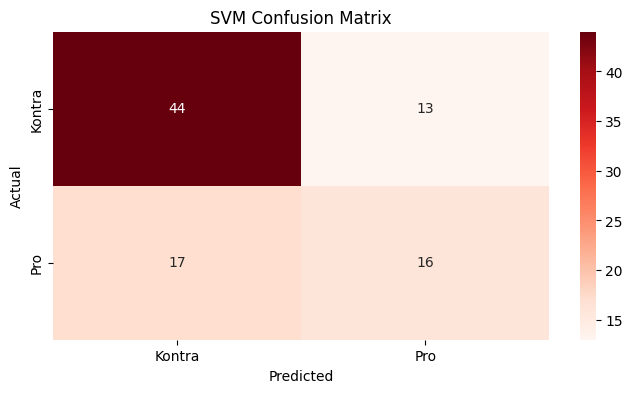

In [244]:
# Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Kontra', 'Pro'],
            yticklabels=['Kontra', 'Pro'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

In [240]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto',1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel type
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)


best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)

best_svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Best SVM Accuracy: {best_svm_accuracy}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best SVM Accuracy: 0.7111111111111111


In [243]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.95      0.81        57
           1       0.77      0.30      0.43        33

    accuracy                           0.71        90
   macro avg       0.74      0.63      0.62        90
weighted avg       0.73      0.71      0.67        90



In [238]:
from sklearn.model_selection import cross_val_score

cros_val = cross_val_score(svm_rbf, X_train, y_train, cv=5)
print("Akurasi Cross-Validation per Fold:", cros_val)
print("Akurasi Rata-rata:", np.mean(cros_val))

Akurasi Cross-Validation per Fold: [0.55555556 0.56338028 0.56338028 0.56338028 0.54929577]
Akurasi Rata-rata: 0.5589984350547732


# **Neural Network**

In [251]:
pip install tensorflow

In [249]:
pip install keras

In [252]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

ModuleNotFoundError: No module named 'keras.layers.recurrent'

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index)+1,
                    300, input_length=X_train.shape[1]))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary